In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [386]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo
from MapMatching import MapMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [387]:
import copy
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass
    
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())
            
class NuscenesSimulation():
    def __init__(self, model, scene_id=5, **kwargs):
        self.model = model
        directory = kwargs.pop('directory', r"/home/kfir/workspace/nuScenes/v1.0-trainval")
        self.mm = kwargs.pop('mm', False)
        self.nmax = kwargs.pop('Nmax', 800)
        self.dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id)
        #self.video = NuscenesVideo(history=True, scene=scene)
        #self.video_debug = NuscenesVideoDebug(history=True, scene=scene)
        self.pf_video = PFVideo(history=True, scene=scene, N=self.nmax)
        self.map_matching = MapMatching(N=200)
        self.lane = None
        self.scene = scene
        
    def getBestLane(self, prior):
        if self.lane is None:
                self.lane = prior[0]
                lane = prior[0]
        else:
            for pr in prior:
                if 1:#if np.linalg.norm(self.lane["poly"][1]-pr["poly"][1]) < 2 and np.linalg.norm(self.lane["poly"][0]-pr["poly"][0]) < 0.1:
                    lane = pr
                    self.lane = pr

        lanes = [lane]
        return lanes
    
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
        
    def run(self,start, N, generate_video=False, video_with_priors=False, debug=False, translate=True):
        start_idx = start
        first = True
        for t in range(start_idx,start_idx + N):
            print(f"frame {t}")
            zw, covw, prior, video_data, nusc_map = self.dataset.getData(t)
            if first:
                translation = np.array(video_data["pos"][0:2])
                print("translation", translation)
                first = False
                
            #lanes = self.getBestLane(prior)
            lanes = copy.deepcopy(prior)
            if translate:
                lanes = self.translatePrior(translation, lanes)
                zw = self.translateMeasurements(zw, translation)
            prior_list = []
            for lane in lanes:
                (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
                prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
    
            points, polynoms = self.model.run(zw,covw,prior_list)
            if translate:
                points, polynoms = self.translateOutput(points, polynoms, -1*translation)
                
            #Run map-matching!
            if self.mm:
                extended_tracks = self.model.getExtendedTracks()
                orig_world_ref = video_data["pos_imu"]
                world_ref = np.array([orig_world_ref[0]-translation[0], orig_world_ref[1]-translation[1]]) 
                self.map_matching.run(extended_tracks, nusc_map, orig_world_ref, world_ref, video_data["rot"], video_data["heading"], video_data["odometry"])
            
            try:
                self.video.save(t,video_data, polynoms, nusc_map, video_with_priors=video_with_priors)
            except:
                pass
            try:
                self.video_debug.save(t,video_data, polynoms,points, nusc_map,self.model.getDebugInfo(), video_with_priors=video_with_priors)
            except:
                pass

            if self.mm:
                mm_results = self.map_matching.getResults()
                mm_results["pf_best_pos"] += translation[0:2]
                mm_results["pf_mean_pos"] += translation[0:2]
                print("mm_results[pf_mean_pos]", mm_results["pf_mean_pos"], "IMU pos", video_data["pos_imu"], "GT", video_data["pos"])
                self.pf_video.save(t,video_data, mm_results, polynoms, nusc_map)
        
        if generate_video:
            try:
                self.video.generate(name=f"video\scene{self.scene}.avi", fps=5)
            except:
                pass
            try:
                self.video_debug.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
            try:
                self.pf_video.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass

In [ ]:
from tracker import Tracker
model = Tracker()
#sim = DynamicSimulation(model)
scene = 426
sim = NuscenesSimulation(model,scene_id=scene, mm=True, Nmax=800)
sim.run(start=90, N=620, generate_video=True, video_with_priors=True, debug=False)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport


No handles with labels found to put in legend.
No handles with labels found to put in legend.


frame 90
ridx 782 rot_imu.shape (15707, 2)
translation [309.1440058 668.7799789]
Number of point tracks before run() 0
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [309.14375302 668.77997487] IMU pos [309.1439659  668.77989518   0.        ] GT [309.1440057979007, 668.7799788974357, 0.0]
frame 91
ridx 790 rot_imu.shape (15707, 2)
Number of point tracks before run() 55
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [309.13897858 668.78514592] IMU pos [309.1439659  668.77989518   0.        ] GT [309.14402876530903, 668.7799674290491, 0.0]
frame 92
ridx 797 rot_imu.shape (15707, 2)
Number of point tracks before run() 61
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [309.14649317 668.78839267] IMU pos [309.1439659  668.77989518   0.        ] GT [309.1440480872666, 668.779957642414, 0.0]
frame 93
ridx 811 rot_imu.shape (15707, 2)
Number of point tracks before run() 67
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [30

mm_results[pf_mean_pos] [307.83447103 669.44599213] IMU pos [307.83591748 669.4807677    0.        ] GT [307.6570108187566, 669.5839596229364, 0.0]
frame 111
ridx 965 rot_imu.shape (15707, 2)
Number of point tracks before run() 106
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
mm_results[pf_mean_pos] [307.5557379 669.5791012] IMU pos [307.54121487 669.64201102   0.        ] GT [307.2925782176512, 669.7834812651777, 0.0]
frame 112
ridx 972 rot_imu.shape (15707, 2)
Number of point tracks before run() 114
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object

frame 127
ridx 1097 rot_imu.shape (15707, 2)
Number of point tracks before run() 109
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
mm_results[pf_mean_pos] [304.10849314 671.7510372 ] IMU pos [304.07763789 671.79268127   0.        ] GT [303.46754815274426, 672.1485006742737, 0.0]
frame 128
ridx 1103 rot_imu.shape (15707, 2)
Number of point tracks before run() 108
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
mm_results[pf_mean_pos] [303.90953794 671.91740281] IMU pos [303.8635779  671.96063783   0.        ] GT [303.2418040333837, 672.3235098300379, 0.0]
frame 129
ridx 1118 rot_imu.shape (15707, 2)
Number of point tracks before run() 105
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
m

frame 151
ridx 1300 rot_imu.shape (15707, 2)
Number of point tracks before run() 71
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [300.28293859 678.64027106] IMU pos [300.06125446 678.51906595   0.        ] GT [299.30059706230077, 679.1109893272253, 0.0]
frame 152
ridx 1307 rot_imu.shape (15707, 2)
Number of point tracks before run() 61
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [300.24445855 678.92106936] IMU pos [300.02720998 678.82626006   0.        ] GT [299.27209691637563, 679.4087336660345, 0.0]
frame 153
ridx 1321 rot_imu.shape (15707, 2)
Number of point tracks before run() 54
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [300.23129443 679.45141576] IMU pos [299.99667005 679.36993081   0.        ] GT [299.24413195113766, 679.9704903041023, 0.0]
frame 154
ridx 1329 rot_imu.shape (15707, 2)
Number of point tracks before run() 57
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [300.24593738 679.69655146] I

frame 179
ridx 1540 rot_imu.shape (15707, 2)
Number of point tracks before run() 92
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
mm_results[pf_mean_pos] [302.81062075 687.54807632] IMU pos [302.64227138 687.27297282   0.        ] GT [302.18765373025053, 688.2667407028433, 0.0]
frame 180
ridx 1547 rot_imu.shape (15707, 2)
Number of point tracks before run() 100
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
mm_results[pf_mean_pos] [302.9785248  687.71210211] IMU pos [302.79985829 687.49761259   0.        ] GT [302.35744276727837, 688.5029044849396, 0.0]
frame 181
ridx 1562 rot_imu.shape (15707, 2)
Number of point tracks before run() 109
Number of extended tracks before run() 2
Updating extended object track =  1
mm_results[pf_mean_pos] [303.42270618 688.30129652] IMU pos [303.14082003 687.96626556   0.        ] GT [302.7318124524936, 689.0057236962714, 0.

frame 200
ridx 1722 rot_imu.shape (15707, 2)
Number of point tracks before run() 145
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
mm_results[pf_mean_pos] [308.16957293 693.59933153] IMU pos [307.64505553 693.679218     0.        ] GT [307.54489712244686, 694.9339040737491, 0.0]
frame 201
ridx 1730 rot_imu.shape (15707, 2)
Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
mm_results[pf_mean_pos] [308.39920122 693.87938897] IMU pos [307.88055825 693.96519319   0.        ] GT [307.7999403779727, 695.2360165048416, 0.0]
frame 202
ridx 1737 rot_imu.shape (15707, 2)
Number of point tracks before run() 149
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  1
mm_results[pf_mean_pos] [308.67486215 694.23078553] IMU pos [308.14897593

frame 224
ridx 1927 rot_imu.shape (15707, 2)
Number of point tracks before run() 113
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2
mm_results[pf_mean_pos] [316.4230386 702.5700243] IMU pos [315.38126586 702.69582713   0.        ] GT [315.77177595370495, 704.2591159689757, 0.0]
frame 225
ridx 1935 rot_imu.shape (15707, 2)
Number of point tracks before run() 112
Number of extended tracks before run() 3
Updating extended object track =  1
mm_results[pf_mean_pos] [316.72007903 702.92411047] IMU pos [315.67482649 703.03602977   0.        ] GT [316.09869595908094, 704.6264289502811, 0.0]
frame 226
ridx 1941 rot_imu.shape (15707, 2)
Number of point tracks before run() 107
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
mm_results[pf_mean_pos] [316.99627635 703.24504846] IMU pos [315.96255467 703.36996914   0.        ] GT [316.4

Number of point tracks before run() 134
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
mm_results[pf_mean_pos] [325.81458301 714.12776053] IMU pos [325.16338987 714.37550478   0.        ] GT [326.0749664767484, 716.1728185252883, 0.0]
frame 250
ridx 2140 rot_imu.shape (15707, 2)
Number of point tracks before run() 135
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
mm_results[pf_mean_pos] [326.14136713 714.52440341] IMU pos [325.47128531 714.75266237   0.        ] GT [326.37001429462725, 716.5240871163236, 0.0]
frame 251
ridx 2146 rot_imu.shape (15707, 2)
Number of point tracks before run() 136
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
mm_results

frame 273
ridx 2337 rot_imu.shape (15707, 2)
Number of point tracks before run() 108
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
mm_results[pf_mean_pos] [332.29462755 723.97430963] IMU pos [332.63017183 723.64856712   0.        ] GT [333.83301270405036, 725.5224483718637, 0.0]
frame 274
ridx 2344 rot_imu.shape (15707, 2)
Number of point tracks before run() 98
Number of extended tracks before run() 3
mm_results[pf_mean_pos] [332.55547464 724.33426537] IMU pos [332.90422983 723.99572326   0.        ] GT [334.09034073774365, 725.8332095921406, 0.0]
frame 275
ridx 2352 rot_imu.shape (15707, 2)
Number of point tracks before run() 106
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  0
mm_results[pf_mean_pos] [332.74247967 724.63504677] IMU pos [333.13157035 724.284042     0.        ] GT [334.3369199291019, 726.1356938652389, 0.0]
frame 276
ridx 2366 rot_imu.shape

frame 297
ridx 2542 rot_imu.shape (15707, 2)
Number of point tracks before run() 109
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2
mm_results[pf_mean_pos] [338.32608318 732.21230792] IMU pos [338.94170926 731.77218052   0.        ] GT [340.43995375404984, 733.7280908373717, 0.0]
frame 298
ridx 2549 rot_imu.shape (15707, 2)
Number of point tracks before run() 114
Number of extended tracks before run() 3
Updating extended object track =  2
mm_results[pf_mean_pos] [338.29869223 732.33727003] IMU pos [339.17116411 732.0675516    0.        ] GT [340.66019237780847, 733.9963461261345, 0.0]
frame 299
ridx 2564 rot_imu.shape (15707, 2)
Number of point tracks before run() 112
Number of extended tracks before run() 3
mm_results[pf_mean_pos] [338.43394856 732.73828405] IMU pos [339.57933768 732.58486261   0.        ] GT [341.0692587445019, 734.504883005488, 0.0]
frame 300
ridx 2571 rot_imu.shape

frame 323
ridx 2768 rot_imu.shape (15707, 2)
Number of point tracks before run() 79
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [342.88723784 738.26233632] IMU pos [345.21819944 739.04328092   0.        ] GT [346.80281339047974, 740.835014265264, 0.0]
frame 324
ridx 2775 rot_imu.shape (15707, 2)
Number of point tracks before run() 81
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [343.0728894  738.48765708] IMU pos [345.40130415 739.26944441   0.        ] GT [346.9600830316738, 741.0262272782822, 0.0]
frame 325
ridx 2783 rot_imu.shape (15707, 2)
Number of point tracks before run() 75
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [343.25127423 738.70341266] IMU pos [345.55922016 739.46889069   0.        ] GT [347.1235685413558, 741.2262447344818, 0.0]
frame 326
ridx 2790 rot_imu.shape (15707, 2)
Number of point tracks before run() 72
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [343.40549542 738.91614758] IMU 

frame 353
ridx 3030 rot_imu.shape (15707, 2)
Number of point tracks before run() 82
Number of extended tracks before run() 1
Updating extended object track =  0
mm_results[pf_mean_pos] [346.63218362 744.55697813] IMU pos [348.99282494 745.31421357   0.        ] GT [350.543763236376, 746.9401218945839, 0.0]
frame 354
ridx 3037 rot_imu.shape (15707, 2)
Number of point tracks before run() 75
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [346.70529148 744.67514631] IMU pos [349.05934868 745.4567541    0.        ] GT [350.624230246327, 747.1063967929754, 0.0]
frame 355
ridx 3052 rot_imu.shape (15707, 2)
Number of point tracks before run() 70
Number of extended tracks before run() 1
Updating extended object track =  0
mm_results[pf_mean_pos] [346.8473128  744.97408529] IMU pos [349.19829036 745.75764345   0.        ] GT [350.79201396139024, 747.4584035991714, 0.0]
frame 356
ridx 3060 rot_imu.shape (15707, 2)
Number of point tracks before run() 74
Number of extended tracks 

mm_results[pf_mean_pos] [348.68699261 750.70878386] IMU pos [351.08616484 751.51364255   0.        ] GT [352.80261049095134, 753.4571439806181, 0.0]
frame 381
ridx 3270 rot_imu.shape (15707, 2)
Number of point tracks before run() 96
Number of extended tracks before run() 2
Updating extended object track =  1
mm_results[pf_mean_pos] [348.74755667 750.99518194] IMU pos [351.14684832 751.7813072    0.        ] GT [352.874132998445, 753.7607300146499, 0.0]
frame 382
ridx 3277 rot_imu.shape (15707, 2)
Number of point tracks before run() 89
Number of extended tracks before run() 2
mm_results[pf_mean_pos] [348.79594027 751.2868159 ] IMU pos [351.21495385 752.08435411   0.        ] GT [352.945922228389, 754.0733345314023, 0.0]
frame 383
ridx 3284 rot_imu.shape (15707, 2)
Number of point tracks before run() 87
Number of extended tracks before run() 2
Updating extended object track =  1
mm_results[pf_mean_pos] [348.86070271 751.56565632] IMU pos [351.27364213 752.3469651    0.        ] GT [353.0

frame 409
ridx 3518 rot_imu.shape (15707, 2)
Number of point tracks before run() 125
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [350.55316821 763.13026115] IMU pos [353.84106851 762.96313555   0.        ] GT [356.0737747454964, 766.0235596253539, 0.0]
frame 410
ridx 3526 rot_imu.shape (15707, 2)
Number of point tracks before run() 124
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [350.67277712 763.44196073] IMU pos [353.93539453 763.27999003   0.        ] GT [356.1880276228835, 766.3852762676607, 0.0]
frame 411
ridx 3540 rot_imu.shape (15707, 2)
Number of point tracks before run() 125
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [350.88163135 764.10830063] IMU pos [354.14698004 763.95437498   0.        ] GT [356.40892124945117, 767.0565605711498, 0.0]
frame 412
ridx 3547 rot_imu.shape (15707, 2)
Number of point tracks before run() 133
Number of extended tracks before run() 0
mm_results[pf_mean_pos] [350.98446946 764.42610846]

frame 436
ridx 3750 rot_imu.shape (15707, 2)
Number of point tracks before run() 91
Number of extended tracks before run() 2
mm_results[pf_mean_pos] [354.01919941 772.6616587 ] IMU pos [357.47888473 772.50515342   0.        ] GT [360.0066649156488, 775.9686794433168, 0.0]
frame 437
ridx 3757 rot_imu.shape (15707, 2)
Number of point tracks before run() 92
Number of extended tracks before run() 2
mm_results[pf_mean_pos] [354.117314   772.90820833] IMU pos [357.59277186 772.77600113   0.        ] GT [360.12778110940076, 776.2478327547663, 0.0]
frame 438
ridx 3765 rot_imu.shape (15707, 2)
Number of point tracks before run() 97
Number of extended tracks before run() 2
Updating extended object track =  1
mm_results[pf_mean_pos] [354.2323465  773.15210932] IMU pos [357.70356119 773.04048578   0.        ] GT [360.2599153277056, 776.5526136952527, 0.0]
frame 439
ridx 3779 rot_imu.shape (15707, 2)
Number of point tracks before run() 90
Number of extended tracks before run() 3
mm_results[pf_mean_

frame 461
ridx 3974 rot_imu.shape (15707, 2)
Number of point tracks before run() 120
Number of extended tracks before run() 2
mm_results[pf_mean_pos] [358.91789428 785.46143375] IMU pos [362.38543057 784.93987361   0.        ] GT [365.15347839017045, 788.7998823955431, 0.0]
frame 462
ridx 3980 rot_imu.shape (15707, 2)
Number of point tracks before run() 122
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1
mm_results[pf_mean_pos] [359.10221559 785.77746498] IMU pos [362.54961087 785.35366876   0.        ] GT [365.31468070692176, 789.1991580201916, 0.0]
frame 463
ridx 3988 rot_imu.shape (15707, 2)
Number of point tracks before run() 122
Number of extended tracks before run() 2
mm_results[pf_mean_pos] [359.04985912 785.43655466] IMU pos [362.69212332 785.70861255   0.        ] GT [365.4692479806981, 789.5790911814642, 0.0]
frame 464
ridx 3996 rot_imu.shape (15707, 2)
Number of point tracks before run() 110
Number of extended 

mm_results[pf_mean_pos] [362.91092765 794.2000034 ] IMU pos [366.92198805 795.00603516   0.        ] GT [369.96696762081615, 799.2939503126058, 0.0]
frame 486
ridx 4186 rot_imu.shape (15707, 2)
Number of point tracks before run() 97
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [363.03187342 794.41475086] IMU pos [367.09202448 795.3575353    0.        ] GT [370.15854045004244, 799.678989961791, 0.0]
frame 487
ridx 4194 rot_imu.shape (15707, 2)
Number of point tracks before run() 110
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [363.24061286 794.80411978] IMU pos [367.25514255 795.6950745    0.        ] GT [370.3536897670688, 800.0683332258943, 0.0]
frame 488
ridx 4200 rot_imu.shape (15707, 2)
Number of point tracks before run() 120
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [363.40933362 795.19054545] IMU pos [367.41351577 796.02319127   0.        ] GT [370.5221072424001, 800.4048738752739, 0.0]
frame 489
ridx 4208 rot_imu.sh

mm_results[pf_mean_pos] [367.341147   804.43203331] IMU pos [371.80604688 806.00970984   0.        ] GT [375.17553337489767, 810.6117197012283, 0.0]
frame 515
ridx 4435 rot_imu.shape (15707, 2)
Number of point tracks before run() 136
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [367.42804502 804.6807216 ] IMU pos [371.91826229 806.30198526   0.        ] GT [375.3003361306128, 810.9278074343234, 0.0]
frame 516
ridx 4442 rot_imu.shape (15707, 2)
Number of point tracks before run() 134
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [367.5384092 804.995376 ] IMU pos [372.04333663 806.62988453   0.        ] GT [375.43492580078373, 811.268234718925, 0.0]
frame 517
ridx 4449 rot_imu.shape (15707, 2)
Number of point tracks before run() 134
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [367.64725166 805.32006842] IMU pos [372.15476191 806.92413425   0.        ] GT [375.56478628073864, 811.5985340857632, 0.0]
frame 518
ridx 4463 rot_imu.sh

frame 540
ridx 4644 rot_imu.shape (15707, 2)
Number of point tracks before run() 133
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [370.75959028 813.80104871] IMU pos [375.32794036 815.65463544   0.        ] GT [378.96548720039414, 820.7551927293341, 0.0]
frame 541
ridx 4657 rot_imu.shape (15707, 2)
Number of point tracks before run() 130
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [370.90761382 814.31244957] IMU pos [375.57000158 816.3225727    0.        ] GT [379.2208668890912, 821.4405229513791, 0.0]
frame 542
ridx 4666 rot_imu.shape (15707, 2)
Number of point tracks before run() 131
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [370.81095603 814.38871244] IMU pos [375.68245273 816.6310694    0.        ] GT [379.3592929079116, 821.800629411697, 0.0]
frame 543
ridx 4673 rot_imu.shape (15707, 2)
Number of point tracks before run() 135
Number of extended tracks before run() 1
Updating extended object track =  0
mm_results[pf_me

mm_results[pf_mean_pos] [373.32115315 820.97258143] IMU pos [378.7360464  824.04368835   0.        ] GT [382.6017361574227, 829.3426712006144, 0.0]
frame 566
ridx 4877 rot_imu.shape (15707, 2)
Number of point tracks before run() 137
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [373.45482585 821.24688794] IMU pos [378.86959275 824.29959053   0.        ] GT [382.7348460649696, 829.589008387003, 0.0]
frame 567
ridx 4884 rot_imu.shape (15707, 2)
Number of point tracks before run() 138
Number of extended tracks before run() 1
Updating extended object track =  0
mm_results[pf_mean_pos] [373.60132053 821.48199942] IMU pos [378.98971007 824.52366161   0.        ] GT [382.8658237812235, 829.8231079137902, 0.0]
frame 568
ridx 4892 rot_imu.shape (15707, 2)
Number of point tracks before run() 133
Number of extended tracks before run() 1
mm_results[pf_mean_pos] [373.73091435 821.70516822] IMU pos [379.11064863 824.74280987   0.        ] GT [382.9978756611581, 830.0542390219864, 

In [10]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport
ridx 6 rot_imu.shape (15707, 2)
{'r1': 2.6628204014008063, 't': 0.0, 'r2': 2.6628204014008063, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 14 rot_imu.shape (15707, 2)
{'r1': 2.6627949733861525, 't': 3.6524852475105547e-06, 'r2': 2.6628356991819055, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 22 rot_imu.shape (15707, 2)
{'r1': 2.6628049800421434, 't': 7.044096037610249e-06, 'r2': 2.6628493090488834, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 29 rot_imu.shape (15707, 2)
{'r1': 2.6628207694639165, 't': 8.446427498841755e-06, 'r2': 2.6628268386988614, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 36 rot_imu.shape (15707, 2)
{'r1': 2.662837846370723, 't': 9.197416451494456e-06, 'r2': 2.662849392622197, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 43 rot_imu.shape (15707, 2)
{'r1': 2.662853890011002, 't': 1.0563597206372058e-05, 'r2': 2.

ridx 419 rot_imu.shape (15707, 2)
{'r1': 2.6628961864639202, 't': 8.074256331216348e-05, 'r2': 2.6633560096224014, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 427 rot_imu.shape (15707, 2)
{'r1': 2.662916529245141, 't': 8.24317692128742e-05, 'r2': 2.663371303436499, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 433 rot_imu.shape (15707, 2)
{'r1': 2.662917887445768, 't': 8.399211370483974e-05, 'r2': 2.6633699172530747, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 440 rot_imu.shape (15707, 2)
{'r1': 2.6629166347061353, 't': 8.557581252731409e-05, 'r2': 2.6633884450998355, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 447 rot_imu.shape (15707, 2)
{'r1': 2.662894564602469, 't': 8.644941193414898e-05, 'r2': 2.6634066357875907, 'trns': array([309.1439659 , 668.77989518,   0.        ])}
ridx 461 rot_imu.shape (15707, 2)
{'r1': 2.662946791759234, 't': 8.987556899918162e-05, 'r2': 2.6634344613423417, 'trns': array([309.14

ridx 833 rot_imu.shape (15707, 2)
{'r1': 2.6613714233162833, 't': 0.00209417769272183, 'r2': 2.6608655986610685, 'trns': array([309.12646547, 668.78900083,   0.        ])}
ridx 841 rot_imu.shape (15707, 2)
{'r1': 2.660630807447412, 't': 0.008636977851915759, 'r2': 2.659795017421246, 'trns': array([309.10943907, 668.79788278,   0.        ])}
ridx 849 rot_imu.shape (15707, 2)
{'r1': 2.6595125399233783, 't': 0.0017655383575832884, 'r2': 2.6586509071484294, 'trns': array([309.07015979, 668.81843079,   0.        ])}
ridx 862 rot_imu.shape (15707, 2)
{'r1': 2.6571290546974087, 't': 0.025945949371885133, 'r2': 2.6567661637611137, 'trns': array([309.00138575, 668.85457498,   0.        ])}
ridx 870 rot_imu.shape (15707, 2)
{'r1': 2.655871473656139, 't': 0.03343143960674916, 'r2': 2.6553955522079957, 'trns': array([308.94935698, 668.88201009,   0.        ])}
ridx 878 rot_imu.shape (15707, 2)
{'r1': 2.6543800460149547, 't': 0.0293718500425261, 'r2': 2.6540489556973186, 'trns': array([308.87066781

ridx 1241 rot_imu.shape (15707, 2)
{'r1': 1.9390982334532973, 't': 0.975802709549498, 'r2': 1.9499758933307372, 'trns': array([300.59528256, 676.33513007,   0.        ])}
ridx 1249 rot_imu.shape (15707, 2)
{'r1': 1.9076521414178276, 't': 0.962455057709648, 'r2': 1.9171773343472418, 'trns': array([300.490731  , 676.62444065,   0.        ])}
ridx 1256 rot_imu.shape (15707, 2)
{'r1': 1.8785647058544674, 't': 0.9607352911495842, 'r2': 1.892432112367529, 'trns': array([300.40476985, 676.88211706,   0.        ])}
ridx 1271 rot_imu.shape (15707, 2)
{'r1': 1.816988575824767, 't': 0.9647818577310042, 'r2': 1.8247263649469887, 'trns': array([300.26294539, 677.42794604,   0.        ])}
ridx 1278 rot_imu.shape (15707, 2)
{'r1': 1.785711648255313, 't': 0.9603754389462181, 'r2': 1.797775208698825, 'trns': array([300.1974791 , 677.71104475,   0.        ])}
ridx 1286 rot_imu.shape (15707, 2)
{'r1': 1.754570185884225, 't': 0.9617059855177362, 'r2': 1.7667163271742665, 'trns': array([300.14192478, 677.9

ridx 1650 rot_imu.shape (15707, 2)
{'r1': 0.8943492247249403, 't': 1.1915107310320434, 'r2': 0.9034799609551475, 'trns': array([305.37407824, 690.86385303,   0.        ])}
ridx 1664 rot_imu.shape (15707, 2)
{'r1': 0.8913476193470807, 't': 1.1877164323240228, 'r2': 0.9010773889345115, 'trns': array([305.81529985, 691.41871135,   0.        ])}
ridx 1671 rot_imu.shape (15707, 2)
{'r1': 0.8892787427978852, 't': 1.2396055698577306, 'r2': 0.898782210029925, 'trns': array([306.02003918, 691.67491057,   0.        ])}
ridx 1679 rot_imu.shape (15707, 2)
{'r1': 0.8875642896818429, 't': 1.2667086237947434, 'r2': 0.8973760713976401, 'trns': array([306.22379134, 691.92910892,   0.        ])}
ridx 1686 rot_imu.shape (15707, 2)
{'r1': 0.8863010992927018, 't': 1.2583004064914944, 'r2': 0.896428262826012, 'trns': array([306.46857637, 692.23387524,   0.        ])}
ridx 1692 rot_imu.shape (15707, 2)
{'r1': 0.884725648282259, 't': 1.252715390384329, 'r2': 0.894885044908551, 'trns': array([306.69597568, 692

ridx 2052 rot_imu.shape (15707, 2)
{'r1': 0.8712136470245391, 't': 1.8045524099806332, 'r2': 0.8806280852756498, 'trns': array([321.99152838, 710.52110818,   0.        ])}
ridx 2065 rot_imu.shape (15707, 2)
{'r1': 0.8730454586945581, 't': 1.8860805017970512, 'r2': 0.8822539328939639, 'trns': array([322.56412385, 711.21272897,   0.        ])}
ridx 2073 rot_imu.shape (15707, 2)
{'r1': 0.8739419795452733, 't': 1.8682923233005544, 'r2': 0.8830933077655604, 'trns': array([322.88436951, 711.60018034,   0.        ])}
ridx 2080 rot_imu.shape (15707, 2)
{'r1': 0.8744546428390061, 't': 1.87552398477, 'r2': 0.8837024416562375, 'trns': array([323.16996036, 711.94615511,   0.        ])}
ridx 2088 rot_imu.shape (15707, 2)
{'r1': 0.8749941522196407, 't': 1.9134907207046545, 'r2': 0.8846049327259538, 'trns': array([323.4518407 , 712.28824259,   0.        ])}
ridx 2095 rot_imu.shape (15707, 2)
{'r1': 0.8756850911363121, 't': 1.885496375472974, 'r2': 0.8853762448408858, 'trns': array([323.77466138, 712.

ridx 2469 rot_imu.shape (15707, 2)
{'r1': 0.9093230138991226, 't': 2.3642527978082994, 'r2': 0.9145889776221413, 'trns': array([336.80471912, 728.99975621,   0.        ])}
ridx 2475 rot_imu.shape (15707, 2)
{'r1': 0.9089924587260875, 't': 2.353357820766603, 'r2': 0.9147650321503911, 'trns': array([337.05053671, 729.31780554,   0.        ])}
ridx 2483 rot_imu.shape (15707, 2)
{'r1': 0.9099782138274056, 't': 2.3462633148045553, 'r2': 0.9159297501764101, 'trns': array([337.26003282, 729.58963766,   0.        ])}
ridx 2491 rot_imu.shape (15707, 2)
{'r1': 0.9117673386359729, 't': 2.3819930280902413, 'r2': 0.9167552257805381, 'trns': array([337.47474274, 729.868794  ,   0.        ])}
ridx 2498 rot_imu.shape (15707, 2)
{'r1': 0.9124246682688582, 't': 2.4002395886541477, 'r2': 0.9161971109399115, 'trns': array([337.67711704, 730.13162524,   0.        ])}
ridx 2504 rot_imu.shape (15707, 2)
{'r1': 0.9107275998186707, 't': 2.4155207169054687, 'r2': 0.9154342285091376, 'trns': array([337.90609179,

ridx 2876 rot_imu.shape (15707, 2)
{'r1': 1.0304673363386814, 't': 2.359490188687721, 'r2': 1.0267385788057692, 'trns': array([347.27414363, 741.96968942,   0.        ])}
ridx 2883 rot_imu.shape (15707, 2)
{'r1': 1.0391304534849355, 't': 2.3813910066767483, 'r2': 1.0360618186451698, 'trns': array([347.37392153, 742.13789243,   0.        ])}
ridx 2891 rot_imu.shape (15707, 2)
{'r1': 1.0465524784930544, 't': 2.3908395715577915, 'r2': 1.0452937342863984, 'trns': array([347.47200902, 742.30679092,   0.        ])}
ridx 2898 rot_imu.shape (15707, 2)
{'r1': 1.054924259212062, 't': 2.3838767514231596, 'r2': 1.051962898296468, 'trns': array([347.58027754, 742.49611408,   0.        ])}
ridx 2913 rot_imu.shape (15707, 2)
{'r1': 1.0705309957118339, 't': 2.3696705933875397, 'r2': 1.069710722762071, 'trns': array([347.7676583, 742.8377261,   0.       ])}
ridx 2920 rot_imu.shape (15707, 2)
{'r1': 1.079425896466807, 't': 2.346650077148821, 'r2': 1.0770599784360724, 'trns': array([347.86170759, 743.012

ridx 3291 rot_imu.shape (15707, 2)
{'r1': 1.3616605298105602, 't': 2.690706532770763, 'r2': 1.3524105989661968, 'trns': array([351.33309956, 752.61472174,   0.        ])}
ridx 3306 rot_imu.shape (15707, 2)
{'r1': 1.362517026406457, 't': 2.689474889909159, 'r2': 1.353448634672505, 'trns': array([351.46717762, 753.22153517,   0.        ])}
ridx 3312 rot_imu.shape (15707, 2)
{'r1': 1.3624114047138811, 't': 2.705945717717085, 'r2': 1.3539430671670547, 'trns': array([351.53047162, 753.50867018,   0.        ])}
ridx 3321 rot_imu.shape (15707, 2)
{'r1': 1.36264927620297, 't': 2.7511070903939623, 'r2': 1.354823214018141, 'trns': array([351.59235554, 753.79059877,   0.        ])}
ridx 3335 rot_imu.shape (15707, 2)
{'r1': 1.3621847644745022, 't': 2.757639662031983, 'r2': 1.3545292130094089, 'trns': array([351.73695353, 754.44842204,   0.        ])}
ridx 3350 rot_imu.shape (15707, 2)
{'r1': 1.3608607708085168, 't': 2.8006557399658134, 'r2': 1.3540071316493283, 'trns': array([351.87894975, 755.092

ridx 3714 rot_imu.shape (15707, 2)
{'r1': 1.1653006854437409, 't': 4.247994916550364, 'r2': 1.1720495826184163, 'trns': array([356.88082744, 771.08990337,   0.        ])}
ridx 3728 rot_imu.shape (15707, 2)
{'r1': 1.1650983718893286, 't': 4.276498528751796, 'r2': 1.1712971182823064, 'trns': array([357.12286082, 771.66220349,   0.        ])}
ridx 3735 rot_imu.shape (15707, 2)
{'r1': 1.165328541405959, 't': 4.272245737758991, 'r2': 1.171423451600304, 'trns': array([357.23855225, 771.93585037,   0.        ])}
ridx 3743 rot_imu.shape (15707, 2)
{'r1': 1.1660361539687147, 't': 4.290817903561436, 'r2': 1.1716054416151391, 'trns': array([357.35245125, 772.20539343,   0.        ])}
ridx 3750 rot_imu.shape (15707, 2)
{'r1': 1.166732389658973, 't': 4.287853208803776, 'r2': 1.172285767626255, 'trns': array([357.47888473, 772.50515342,   0.        ])}
ridx 3757 rot_imu.shape (15707, 2)
{'r1': 1.1680250414815019, 't': 4.298823876371992, 'r2': 1.1733986273358286, 'trns': array([357.59277186, 772.7760

ridx 4149 rot_imu.shape (15707, 2)
{'r1': 1.1168038198808237, 't': 5.2687986556156154, 'r2': 1.124895327783943, 'trns': array([366.22170353, 793.55558761,   0.        ])}
ridx 4157 rot_imu.shape (15707, 2)
{'r1': 1.115447256466627, 't': 5.254240820800205, 'r2': 1.1236100133162465, 'trns': array([366.4050292 , 793.93678809,   0.        ])}
ridx 4170 rot_imu.shape (15707, 2)
{'r1': 1.1123307843250292, 't': 5.243259895741583, 'r2': 1.1216977923627807, 'trns': array([366.74996005, 794.65050134,   0.        ])}
ridx 4179 rot_imu.shape (15707, 2)
{'r1': 1.1121184858156354, 't': 5.259098494692827, 'r2': 1.1212505359963385, 'trns': array([366.92198805, 795.00603516,   0.        ])}
ridx 4186 rot_imu.shape (15707, 2)
{'r1': 1.1120561712095078, 't': 5.29891409211095, 'r2': 1.1212919006364457, 'trns': array([367.09202448, 795.3575353 ,   0.        ])}
ridx 4194 rot_imu.shape (15707, 2)
{'r1': 1.112539277696289, 't': 5.35970025078735, 'r2': 1.1216360434293264, 'trns': array([367.25514255, 795.6950

ridx 4577 rot_imu.shape (15707, 2)
{'r1': 1.2170151794186108, 't': 6.074327563023025, 'r2': 1.2255680519906171, 'trns': array([374.26424176, 812.69710609,   0.        ])}
ridx 4585 rot_imu.shape (15707, 2)
{'r1': 1.2170920477421174, 't': 6.094265667516001, 'r2': 1.2256985555165512, 'trns': array([374.38006185, 813.01901149,   0.        ])}
ridx 4600 rot_imu.shape (15707, 2)
{'r1': 1.2173346975347545, 't': 6.099475019409003, 'r2': 1.225932506267874, 'trns': array([374.62919806, 813.71195345,   0.        ])}
ridx 4607 rot_imu.shape (15707, 2)
{'r1': 1.2173998279689475, 't': 6.103915795454759, 'r2': 1.2260352484349188, 'trns': array([374.74713333, 814.04007218,   0.        ])}
ridx 4615 rot_imu.shape (15707, 2)
{'r1': 1.2180885883211876, 't': 6.149203346287801, 'r2': 1.226098090883577, 'trns': array([374.86603297, 814.37092544,   0.        ])}
ridx 4622 rot_imu.shape (15707, 2)
{'r1': 1.2178594501033293, 't': 6.196970899061926, 'r2': 1.2260094487156497, 'trns': array([374.97657516, 814.67

ridx 5015 rot_imu.shape (15707, 2)
{'r1': 0.7853590819152114, 't': 6.714551308692715, 'r2': 0.7947635365020483, 'trns': array([381.3131853 , 827.80740056,   0.        ])}
ridx 5022 rot_imu.shape (15707, 2)
{'r1': 0.7638627872608971, 't': 6.697882394346152, 'r2': 0.7762082258908721, 'trns': array([381.45590924, 827.94705912,   0.        ])}
ridx 5029 rot_imu.shape (15707, 2)
{'r1': 0.7427225285151817, 't': 6.712569443548328, 'r2': 0.7588815536114683, 'trns': array([381.57161116, 828.05643684,   0.        ])}
ridx 5036 rot_imu.shape (15707, 2)
{'r1': 0.7216514737364695, 't': 6.733717648562671, 'r2': 0.7359683776337123, 'trns': array([381.68404997, 828.15798431,   0.        ])}
ridx 5051 rot_imu.shape (15707, 2)
{'r1': 0.6804013021094152, 't': 6.711336267642047, 'r2': 0.6897757307511216, 'trns': array([381.94348858, 828.3714608 ,   0.        ])}
ridx 5057 rot_imu.shape (15707, 2)
{'r1': 0.659355643761868, 't': 6.7077870487399265, 'r2': 0.6736045136783543, 'trns': array([382.06264626, 828.

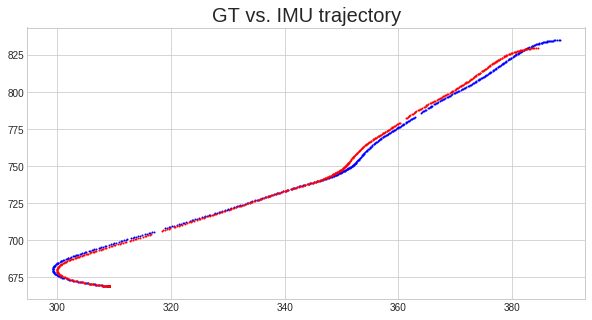

In [9]:
scene = 426
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 600
gt = np.zeros((N, 2))
imu = np.zeros((N, 2))
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu[t, :] = trns1[0:2]
    odom = dataset.getOdometry()
    print(odom)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title("GT vs. IMU trajectory", fontsize=20)
ax.scatter(gt[:, 0],gt[:, 1],color='blue',s=1)
ax.scatter(imu[:, 0],imu[:, 1],color='red',s=1)

In [32]:
import numpy as np
from scipy.spatial.distance import cdist

mat = np.eye(10)
val = np.argwhere(mat > 0)
dists = cdist([(4,0)], val)
print(np.argmin(dists), val[2])
#data = np.random.uniform(0., 1., (1000, 2))

2 [2 2]


In [4]:
from pyquaternion import Quaternion

Quaternion.Inverse()

AttributeError: type object 'Quaternion' has no attribute 'Inverse'

In [351]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport
ridx 6024 rot_imu.shape (15707, 2)


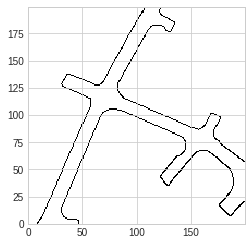

In [379]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')